# Image Segementation FCN

In [1]:
# DL framework
import tensorflow as tf

from datetime import datetime

# common packages
import numpy as np
import os # handling file i/o
import sys
import math
import time # timing epochs

# for ordered dict when building layer components
import collections

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import colors # making colors consistent
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar helper

# read image
from scipy.misc import imread
# + data augmentation
from scipy import ndimage
from scipy import misc

# used for manually saving best params
import pickle

# for shuffling data batches
from sklearn.utils import shuffle

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# helper to create dirs if they don't already exist
def maybe_create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("{} createed".format(dir_path))
    else:
        print("{} already exists".format(dir_path))
    
# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Important Version information
print("Python: {}".format(sys.version_info[:]))
print('TensorFlow: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

Python: (3, 5, 4, 'final', 0)
TensorFlow: 1.4.0
Default GPU Device: /device:GPU:0


In [2]:
# `saver/` will hold tf saver files
maybe_create_dir("saver")
# `best_params/` will hold a serialized version of the best params
# I like to keep this as a backup in case I run into issues with
# the saver files
maybe_create_dir("best_params")
# `tf_logs/` will hold the logs that will be visable in tensorboard
maybe_create_dir("tf_logs")

saver already exists
best_params already exists
tf_logs already exists


In [3]:
meta = "trial_zeros2"

In [4]:
# these two functions (get_model_params and restore_model_params) are 
# ad[a|o]pted from; 
# https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb
def get_model_params():
    global_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {global_vars.op.name: value for global_vars, value in 
            zip(global_vars, tf.get_default_session().run(global_vars))}

def restore_model_params(model_params, g, sess):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: g.get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    sess.run(assign_ops, feed_dict=feed_dict)

# these two functions are used to manually save the best
# model params to disk
def save_obj(obj, name):
    with open('best_params/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('best_params/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
# helper to add an image to the plot and choose whether
# to include the color bar
def implot(mp, ax, SHOW_CB=False):
    cmap = plt.get_cmap('viridis')
    # bounds=[-4,0,4]
    bounds=np.linspace(-0.01, 1, 80)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    im = ax.imshow(mp, interpolation='nearest', origin='lower',
                        cmap=cmap, norm=norm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    if SHOW_CB:
        if np.min(mp) != np.max(mp):
            cbar = plt.colorbar(im, cax=cax, format='%1.2f', boundaries=bounds)
        else:
            cax.set_axis_off()
    else:
        cax.set_axis_off()

    ax.set_axis_off()
    

def feat_plot(mp, ax):
    cmap = plt.get_cmap('viridis')
    bounds=np.linspace(-3, 3, 80)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    img = ax.imshow(mp, interpolation='nearest', origin='lower',
                    cmap=cmap, norm=norm)

    ax.set_axis_off()

def show_masked_result(image, mask):
    # create combined image of (image & mask)
    combined = np.copy(img)
    combined[mask == 0] = [0, 0, 0]

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))

    implot(image, ax1)
    implot(mask, ax2, True)
    implot(combined, ax3)

    plt.grid('off')
    plt.tight_layout()
    plt.show()

In [6]:
def plot_square_maps(all_imgs, plot_as_zero_one=False, img_type="misc", epoch_num=0, SAVE_FIG=False):
    # TODO: this function is a horrible hack job, but it gets the job done
    # it really should be cleaned up
    
    # set up shape, this is a "hack" but it works for now
    if all_imgs.shape[2] % 4 == 0:
        n_col = 4
        n_row = int(all_imgs.shape[2]/n_col)
    elif all_imgs.shape[2] == 2:
        n_row = 1
        n_col = 2
    elif all_imgs.shape[2] == 1:
        n_row = 1
        n_col = 1
    else:
        print(all_imgs.shape)
    fig, ax = plt.subplots(nrows=n_row, ncols=n_col, sharey=True, figsize=(n_col*2,n_row*2))

    k = 0
    if all_imgs.shape[2] == 1:
        cur_img = all_imgs[:,:,0]
        implot(cur_img, ax)
    else:
        if n_row > 1:
            for i in range(ax.shape[0]):
                for j in range(ax.shape[1]):
                    cur_img = all_imgs[:,:,k]
                    k += 1
                    feat_plot(cur_img, ax[i][j])
        else:
            for i in range(ax.shape[0]):
                cur_img = all_imgs[:,:,k]
                if plot_as_zero_one:
                    implot(cur_img, ax[i])
                else:
                    feat_plot(cur_img, ax[i])
                k += 1

    plt.grid('off')
    if SAVE_FIG:
        name_str = '{}_{}_image_{}.png'.format(img_type, epoch_num, i)
        plt.savefig(os.path.join("./misc", name_str), dpi=300)
    plt.show()

In [7]:
# image dimensions (GLOBAL) - [MG_WIDTH x IMG_HEIGHT, CHANNELS]
SQUARE_DIM = 224
if SQUARE_DIM:
    IMG_WIDTH = SQUARE_DIM
    IMG_HEIGHT = SQUARE_DIM
CHANNELS = 3

ROOT_DIR = "../../improving_classification_with_GAN/segmentation/dataset/" + str(SQUARE_DIM) + "_" + str(SQUARE_DIM)

# load entire dataset into memory
# NOTE: depending on your machine, this may not be practical, you may have to
# create a smaller dataset (although this should have already been noticed when
# making this dataset)
X_dev = np.load(ROOT_DIR + '/images.npy')
y_dev = np.load(ROOT_DIR + '/masks.npy')

# test set supplied (doesn't need to come from training data)
# X_cat = np.load(ROOT_DIR + '/cat_imgs.npy')
# y_cat = np.load(ROOT_DIR + '/cat_masks.npy')
# X_dev = np.concatenate((X_dev, X_cat), axis=0)
# y_dev = np.concatenate((y_dev, y_cat), axis=0)
# print("X:{} , y:{}".format(X_cat.shape, y_cat.shape))

# X_dog = np.load(ROOT_DIR + '/dog2_imgs.npy')
# y_dog = np.load(ROOT_DIR + '/dog2_masks.npy')
# X_dev = np.concatenate((X_dev, X_dog), axis=0)
# y_dev = np.concatenate((y_dev, y_dog), axis=0)
# print("X:{} , y:{}".format(X_dog.shape, y_dog.shape))

# shuffle set -- not necessary, but I like to do this in case there
# is some order to the data we don't know about.  Not that important
# for this particular problem (segmentation), but I still feel better
# calling a shuffle before splitting the data
X_dev, y_dev = shuffle(X_dev, y_dev, random_state=42)
print("X:{} , y:{}".format(X_dev.shape, y_dev.shape))

X:(2000, 224, 224, 3) , y:(2000, 224, 224)


## Preprocessing
[preprocess_mask]: ./misc/segmentation_clipping_y.png
[preprocess_image]: ./misc/segmentation_preprocessing_x.png

### Masks
Our mask is currently in non-binary form.  The resize that was used created intermediate values {shown below}.  To address this, we need to clip the values to binary form.

![mask preprocessing][preprocess_mask]


### Input image
The image is currently in [0, 255], this is ok, but we're going to scale the input image to [0,1].  This will be done for each image.  This will be a simple/basic scaling, meaning we'll divide each image pixel (minus the image min) value by the (individual image's) max - min*.
TODO: explain and reference this process

![image preprocessing][preprocess_image]

*NOTE: this methodology may not be best for this and/or your independent problem.

In [8]:
# preprocess mask (example shown above)
# threshold (clip) to [0, 1] where 0:no mask, 1:mask
# convert to datatype int
y_dev = [np.clip(img, 0, 1).astype(np.int32) for img in y_dev]
y_dev = np.asarray(y_dev)

In [9]:
# preprocess image (example shown above)
X_dev = [(image-np.amin(image))/(np.amax(image)-np.amin(image)) for image in X_dev]
X_dev = np.asarray(X_dev)

In [10]:
## Add zeros to dataset

In [11]:
# # Zeros
num_zeros = 1500
X_zeros = np.zeros_like(X_dev[:num_zeros])
y_zeros = np.zeros_like(y_dev[:num_zeros])

X_dev = np.concatenate((X_dev, X_zeros), axis=0)
y_dev = np.concatenate((y_dev, y_zeros), axis=0)

X_dev, y_dev = shuffle(X_dev, y_dev, random_state=42)
print("X:{} , y:{}".format(X_dev.shape, y_dev.shape))

X:(3500, 224, 224, 3) , y:(3500, 224, 224)


In [12]:
# view dataset information
print("Training :  X:{} , y:{}".format(X_dev.shape, y_dev.shape))

Training :  X:(3500, 224, 224, 3) , y:(3500, 224, 224)


In [13]:
# break into validation set
# note: this will be a ridgid split 
# (validation data will not be inluded in the training data)
# NOTE: this may/or may not how you wish to personally approach this
# break into dev / test

# here we'll use 10% for validation (90% training)
split_thresh = int(X_dev.shape[0] * 0.90)
X_train = X_dev[:split_thresh]
y_train = y_dev[:split_thresh]
X_val = X_dev[split_thresh:]
y_val = y_dev[split_thresh:]

print("Training   :  X:{} , y:{}".format(X_train.shape, y_train.shape))
print("Validation :  X:{}  , y:{}".format(X_val.shape, y_val.shape))

Training   :  X:(3150, 224, 224, 3) , y:(3150, 224, 224)
Validation :  X:(350, 224, 224, 3)  , y:(350, 224, 224)


### View examples from current dataset split

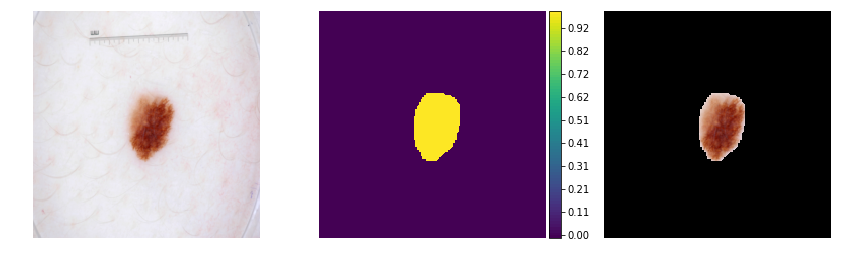

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


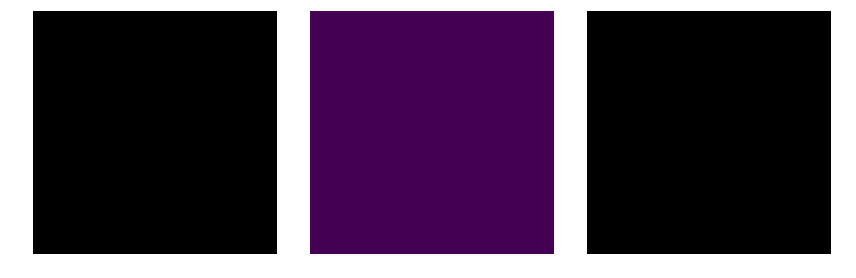

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


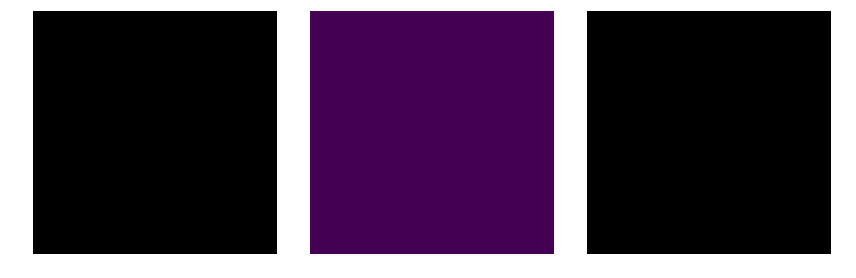

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [14]:
for i in range(3):
    img = X_train[i,:,:]
    mask = y_train[i,:,:]
    show_masked_result(img, mask)
    print(mask)

## Build Graph

In [15]:
def plot_four_array(sess, x, yhat, lesion_prob, X_batch, y_batch, idx, 
                    img_type="misc", epoch_num=0, SAVE_FIG=False):
    y_softmax, y_lesion_prob = sess.run([yhat, lesion_prob],{x:X_batch})
    y_prediction = np.argmax(y_softmax,axis=3)
    y_lesion_prob = y_lesion_prob.reshape(len(X_batch), SQUARE_DIM, SQUARE_DIM)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(12,4))

    prob_img = y_lesion_prob[idx,:,:]
    pred_img = y_prediction[idx,:,:]
    
    implot(X_batch[idx,:,:], ax1)
    implot(y_lesion_prob[idx,:,:], ax2, True)
    implot(y_prediction[idx,:,:], ax3, True)
    implot(y_batch[idx,:,:], ax4, True)

    plt.grid('off')
    plt.tight_layout()
    if SAVE_FIG:
        name_str = '{}_{}_image_{}.png'.format(img_type, epoch_num, idx)
        plt.savefig(os.path.join("./misc", name_str), dpi=300)
    plt.show()

In [16]:
def leaky_relu(x):
    return tf.maximum(0.2*x,x)

# These two functions were adapted from 
# OpenSAP course: Enterprise deep learning with tensorflow
def execute_conv2D(x_in, dims=[3, 3], filters=24, strides=[1, 1],
                   std='xavier', padding='SAME', activation=tf.identity, scope='conv2d'):
    with tf.variable_scope(scope):
        input_shape = x_in.get_shape().as_list()

        # input_shape[0] = batch_size, input_shape[1] = image_width, ++++
        shape = dims + [input_shape[3], filters]

        if std == 'xavier':
            std = np.sqrt(2.0 / (input_shape[1] * input_shape[2] * input_shape[3]))

        weights = tf.Variable(tf.random_normal(shape=shape, stddev=std), name='weights')
        bias = tf.Variable(tf.ones(filters) * std, name='bias')
        conv_out = tf.nn.convolution(x_in, weights, padding, strides=strides)
        conv_out = conv_out + bias

        out = activation(conv_out)
        
        # add featuremaps to collection for later viewing extravaganza
        tf.get_default_graph().add_to_collection("conv_featuremaps", out)

        return out
    

def build_conv_block(x_in, dims=[5,5], filters=[32], num_layers=5, 
                     activation=tf.identity, scope='conv_block'):
    conv_io = x_in
    with tf.variable_scope(scope):
        for i in range(1, num_layers+1):
            # numbering starts at 1, but filter size numbering starts at 0
            scope = 'conv_{}'.format(i)
            if filters[i-1]:
                cur_filter_size = filters[i-1]
            else:
                cur_filter_size = filters[0]
            conv_io = execute_conv2D(conv_io, dims=dims, filters=cur_filter_size, activation=activation, scope=scope)
    return conv_io

In [17]:
def build_fcn_graph():
    global IMG_WIDTH, IMG_HEIGHT, CHANNELS
    
    # number of filters for each layer
    
    filter_size_list = [64,64,64,64,32,32,32,32,16,16,16,16]
    num_layers = len(filter_size_list)
    learning_rate = 1e-3
    
    # could be used to give "importance" to underrepresented class
    # > in this case that would be lesion/non-lesion pixel. For now
    # > the weight will be left as 1:1
    class_weights = np.asarray([1.0, 8.75])
    num_classes=2
    
    reset_graph()
    g = tf.Graph()
    with g.as_default():
        
    
        with tf.name_scope("FCN"):
            with tf.name_scope("inputs"):
                x = tf.placeholder(shape=[None,IMG_WIDTH,IMG_HEIGHT,CHANNELS],dtype=tf.float32)
                y = tf.placeholder(shape=[None,IMG_WIDTH,IMG_HEIGHT],dtype=tf.int32)

            conv_activated = build_conv_block(x, [3,3], filters=filter_size_list, num_layers=num_layers, 
                                              activation=tf.nn.elu, scope="conv_block")

            with tf.name_scope("output"):
                logit = execute_conv2D(conv_activated, dims=[3,3], filters=num_classes, strides=[1, 1],
                                       activation=tf.identity, scope='conv_final')

                yhat = tf.nn.softmax(logit)
                not_lesion_prob, lesion_prob = tf.split(yhat, 2, axis=3)

            # TODO: need to ensure one_hot matches ground truth
            with tf.name_scope("loss"):
                y_truth = tf.one_hot(y, depth=num_classes, axis=3)
                loss_temp = tf.reduce_mean(-y_truth*tf.log(yhat+1e-6),axis=[0,1,2])
#                 loss_temp = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_truth, logits=logit))
                loss_temp = loss_temp*class_weights

                batch_loss = tf.reduce_mean(loss_temp)

            with tf.name_scope("optimize"):
                opt = tf.train.AdamOptimizer(learning_rate)
                training_op = opt.minimize(batch_loss)

            # loss metrics
            with tf.name_scope("metrics"):
                with tf.name_scope("train_metrics") as scope:    
                    train_mean_loss, train_mean_loss_update = tf.metrics.mean(batch_loss)
                    train_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                    train_loss_reset_op = tf.variables_initializer(train_loss_vars, name="train_loss_reset_op")

                with tf.name_scope("val_metrics") as scope:
                    val_mean_loss, val_mean_loss_update = tf.metrics.mean(batch_loss)
                    val_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                    val_loss_reset_op = tf.variables_initializer(val_loss_vars, name="val_loss_reset_op")

                with tf.name_scope("test_metrics") as scope:
                    test_mean_loss, test_mean_loss_update = tf.metrics.mean(batch_loss)
                    test_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                    test_loss_reset_op = tf.variables_initializer(test_loss_vars, name="test_loss_reset_op")

            with tf.name_scope("save_session"):
                init_global = tf.global_variables_initializer()
                init_local = tf.local_variables_initializer()
                saver = tf.train.Saver()

            # create collections
            for node in (init_global, init_local, saver):
                g.add_to_collection("save_init_ops", node)

            for node in (train_mean_loss, train_mean_loss_update, train_loss_reset_op):
                g.add_to_collection("train_metrics_ops", node)

            for node in (val_mean_loss, val_mean_loss_update, val_loss_reset_op):
                g.add_to_collection("val_metrics_ops", node)

            for node in (test_mean_loss, test_mean_loss_update, test_loss_reset_op):
                g.add_to_collection("test_metrics_ops", node)

            for node in (training_op, x, y, yhat, lesion_prob):
                g.add_to_collection("main_ops", node)

            # tensorboard writers
            with tf.name_scope("writers"):
                epoch_train_loss_scalar = tf.summary.scalar('train_epoch_loss', train_mean_loss)
                epoch_train_write_op = tf.summary.merge([epoch_train_loss_scalar], name="epoch_train_write_op")

                epoch_val_loss_scalar = tf.summary.scalar('validation_epoch_loss', val_mean_loss)
                epoch_val_write_op = tf.summary.merge([epoch_val_loss_scalar], name="epoch_val_write_op")

            for node in (epoch_train_write_op, epoch_val_write_op):
                g.add_to_collection("write_ops", node)

            print("model built")

        return g
print("ready")

ready


In [18]:
def run_model():
    global X_train, X_val
    global y_train, y_val
    global meta
    
    num_epochs = 60
    batch_size = 64
    checks_since_last_progress = 0
    best_validation_loss = np.infty
    EARLY_STOPPING_THRESH = 40
    
    # Tensorboard 
    now = datetime.now().strftime("%d%b%Y_%H%M%S")
    logdir = "{}/{}/{}/".format("tf_logs", meta, now)
    
    # build graph and obtain handle on important operations
    g = build_fcn_graph()
    train_mean_loss, train_mean_loss_update, train_loss_reset_op = g.get_collection("train_metrics_ops")
    val_mean_loss, val_mean_loss_update, val_loss_reset_op = g.get_collection("val_metrics_ops")
    init_global, init_local, saver = g.get_collection("save_init_ops")
    training_op, x, y, yhat, lesion_prob = g.get_collection("main_ops")
    epoch_train_write_op, epoch_val_write_op = g.get_collection("write_ops")
     
    with tf.Session(graph=g) as sess:
        sess.run([init_global, init_local, train_loss_reset_op, val_loss_reset_op])
        
        epoch_train_writer = tf.summary.FileWriter(os.path.join(logdir, "train/"))
        epoch_val_writer = tf.summary.FileWriter(os.path.join(logdir, "val/"))
        epoch_train_writer.add_graph(sess.graph)
        
        low_i = 0
        high_i = 0
        for epoch in range(num_epochs):
            EPOCH_START_TIME = time.time()
            
            mini_step = 0
            for iteration in range(len(X_train) // batch_size):
                mini_step += 1
                X_tr, y_tr = shuffle(X_train, y_train, random_state=42)
                low_i = iteration*batch_size
                high_i = (iteration+1)*batch_size
                X_batch = X_tr[low_i:high_i]     
                y_batch = y_tr[low_i:high_i]

                sess.run([train_mean_loss_update,training_op],{x:X_batch,y:y_batch})
                
                # validation
                # TODO: move 8 outside main loop as a percent of iterations (size/batch_size)
                if mini_step == 0 or mini_step % 8 == 0:
                    lower_i = 0
                    higher_i = 0
                    for val_itter in range(len(X_val) // batch_size):
                        lower_i = val_itter*batch_size
                        higher_i = (val_itter+1)*batch_size
                        X_val_batch = X_val[lower_i:higher_i]
                        y_val_batch = y_val[lower_i:higher_i]
                        sess.run([val_mean_loss_update],{x:X_val_batch,y:y_val_batch})
                    X_val_batch = X_val[higher_i:]
                    y_val_batch = y_val[higher_i:]
                    if len(X_val_batch) > 0:
                        sess.run([val_mean_loss_update],{x:X_val_batch,y:y_val_batch})
                
            X_batch = X_train[high_i:]
            y_batch = y_train[high_i:]
            if len(X_batch) > 0:
                sess.run([train_mean_loss_update,training_op],{x:X_batch,y:y_batch})
            
            # average val loss after entire epoch
            avg_epoch_train_loss, avg_epoch_val_loss = sess.run([train_mean_loss, val_mean_loss])
            
            epoch_train_summary = sess.run(epoch_train_write_op)
            epoch_train_writer.add_summary(epoch_train_summary, epoch)
            epoch_train_writer.flush()
            
            epoch_val_summary = sess.run(epoch_val_write_op)
            epoch_val_writer.add_summary(epoch_val_summary, epoch)
            epoch_val_writer.flush()
            
            print("E:{} train:{:.6f} val:{:.6f}".format(epoch, avg_epoch_train_loss, avg_epoch_val_loss))
            
            # save current best validation params
            if avg_epoch_val_loss < best_validation_loss:
                best_validation_loss = avg_epoch_val_loss
                best_model_params = get_model_params()
                save_obj(best_model_params, meta)
                print("Best params saved @./best_params/{} | val loss {:.5f}".format(meta, best_validation_loss))
                checks_since_last_progress = 0
            else:
                checks_since_last_progress += 1

            if checks_since_last_progress >= EARLY_STOPPING_THRESH:
                print("EARLY STOPPING!")
                break
            
            # estimate time remaining
            EPOCH_END_TIME = time.time()
            EPOCH_ELAPSED_TIME = EPOCH_END_TIME - EPOCH_START_TIME
            EST_TIME_REMAINING = (((EPOCH_ELAPSED_TIME) * (num_epochs - epoch)) / 60)
            print("E time {:.1f} secs, Est.Time Remain: {:.1f} mins".format(EPOCH_ELAPSED_TIME, EST_TIME_REMAINING))
            print("-----------------------------")
            
            
            # display images
            plot_four_array(sess, x, yhat, lesion_prob, X_batch, y_batch, 4)
            plot_four_array(sess, x, yhat, lesion_prob, X_batch, y_batch, 5)
            plot_four_array(sess, x, yhat, lesion_prob, X_batch, y_batch, 6)
            
            sess.run([train_loss_reset_op, val_loss_reset_op])
        epoch_train_writer.close()
        epoch_val_writer.close()
    
        # save final location (best params can be loaded with pkl)
        #saver_path = os.join("saver", meta)
        #save_path = saver.save(sess, saver_path)

print("ready")

ready


## Train Model

model built
E:0 train:0.654136 val:0.653460
Best params saved @./best_params/trial_zeros2 | val loss 0.65346
E time 114.9 secs, Est.Time Remain: 114.9 mins
-----------------------------


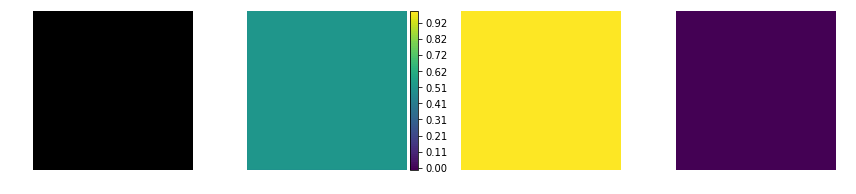

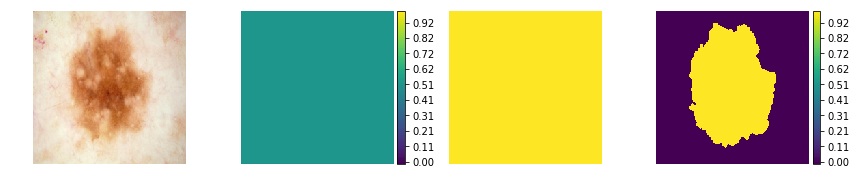

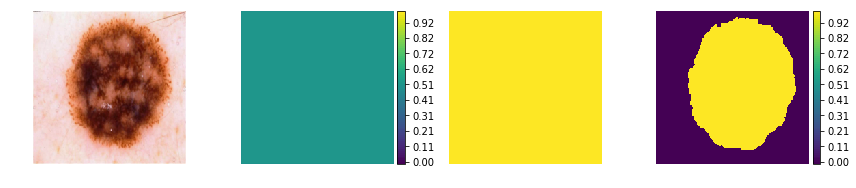

E:1 train:0.589497 val:0.571411
Best params saved @./best_params/trial_zeros2 | val loss 0.57141
E time 109.5 secs, Est.Time Remain: 107.7 mins
-----------------------------


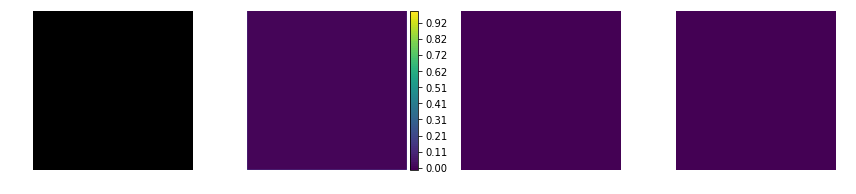

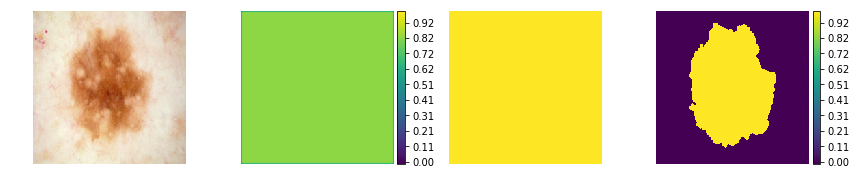

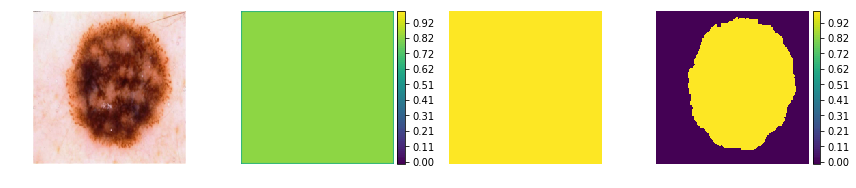

E:2 train:0.461729 val:0.455059
Best params saved @./best_params/trial_zeros2 | val loss 0.45506
E time 108.5 secs, Est.Time Remain: 104.8 mins
-----------------------------


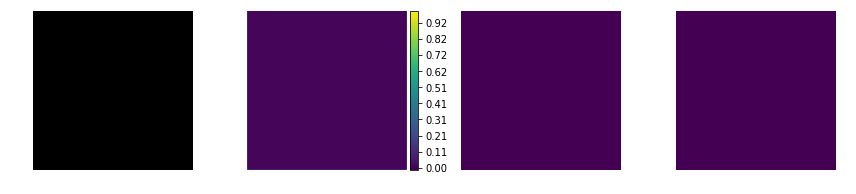

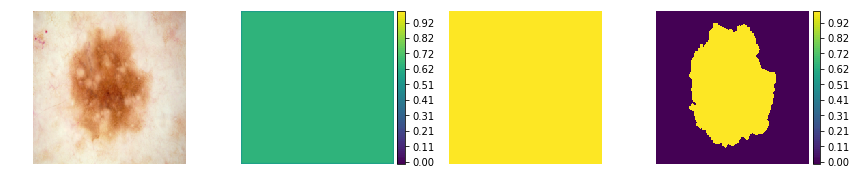

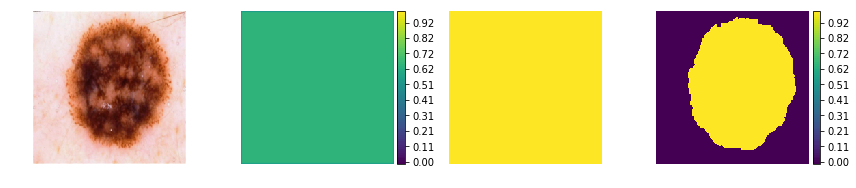

E:3 train:0.455698 val:0.451462
Best params saved @./best_params/trial_zeros2 | val loss 0.45146
E time 107.3 secs, Est.Time Remain: 102.0 mins
-----------------------------


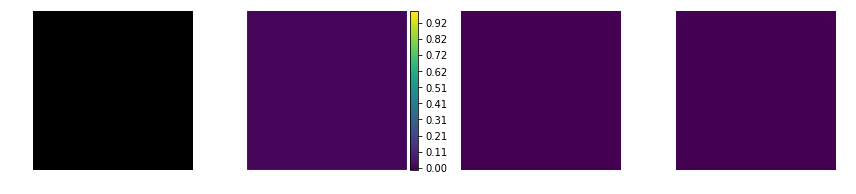

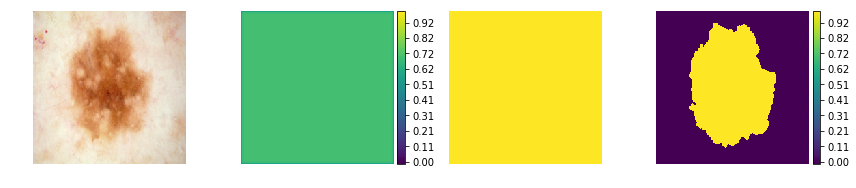

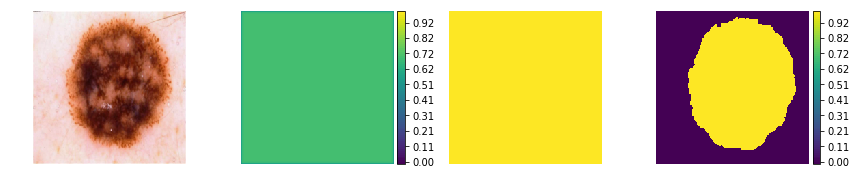

E:4 train:0.457290 val:0.453019
E time 106.1 secs, Est.Time Remain: 99.0 mins
-----------------------------


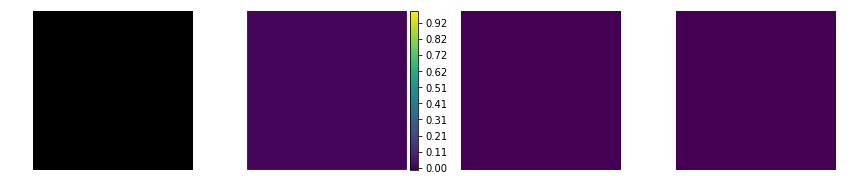

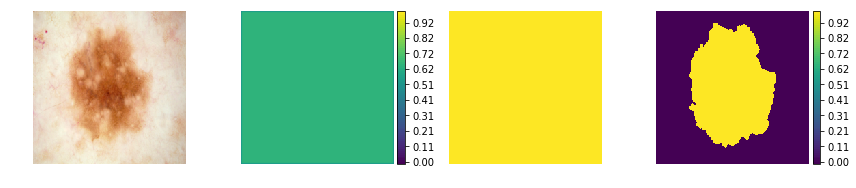

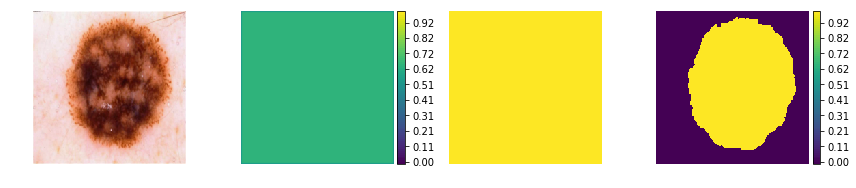

E:5 train:0.455826 val:0.450935
Best params saved @./best_params/trial_zeros2 | val loss 0.45094
E time 105.9 secs, Est.Time Remain: 97.1 mins
-----------------------------


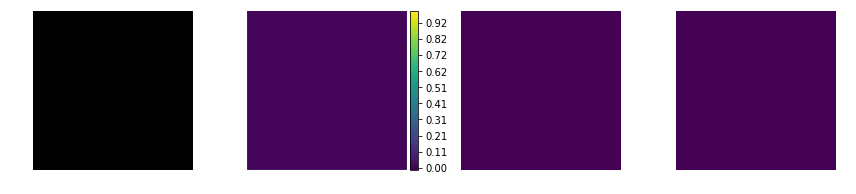

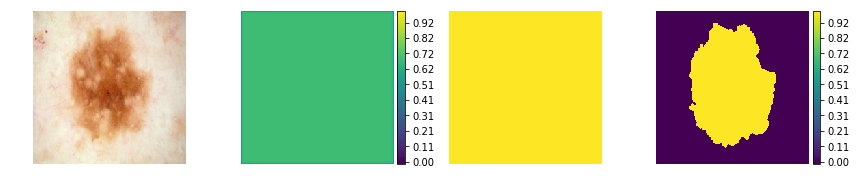

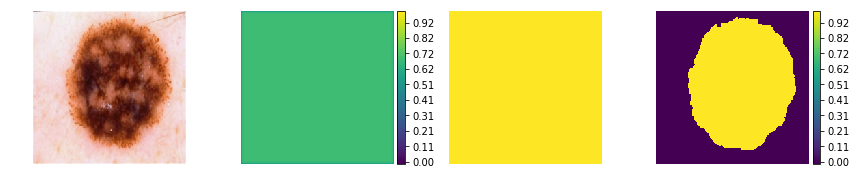

E:6 train:0.455047 val:0.450928
Best params saved @./best_params/trial_zeros2 | val loss 0.45093
E time 106.3 secs, Est.Time Remain: 95.6 mins
-----------------------------


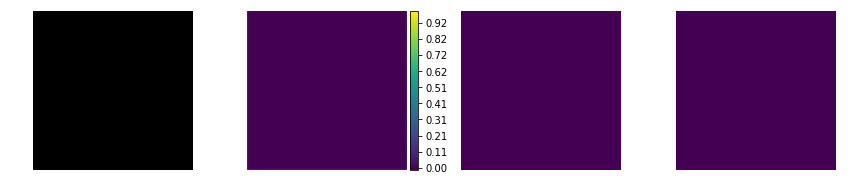

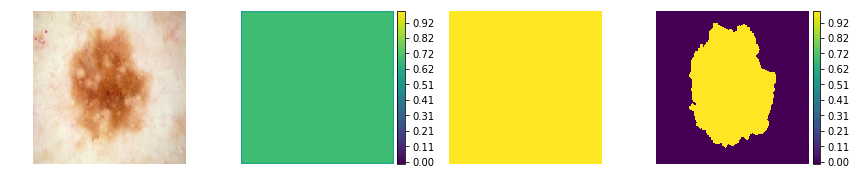

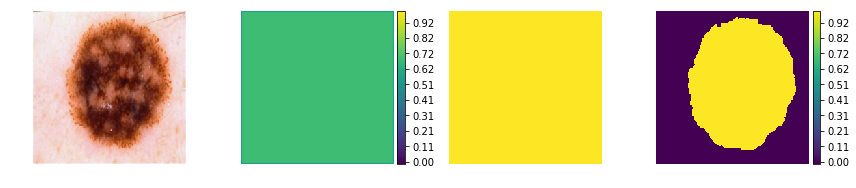

E:7 train:0.457500 val:0.455038
E time 107.2 secs, Est.Time Remain: 94.7 mins
-----------------------------


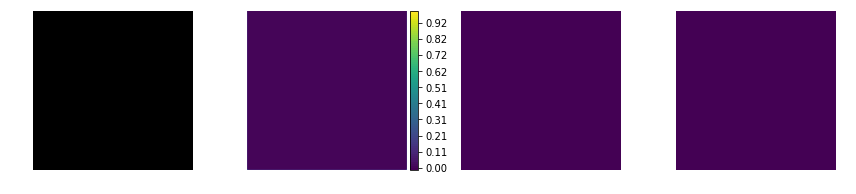

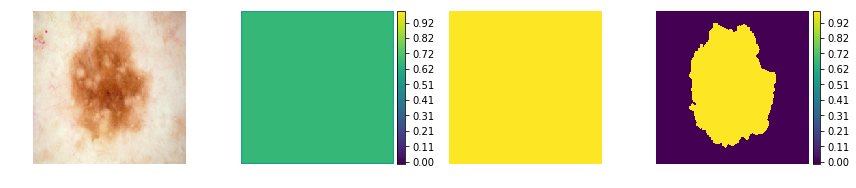

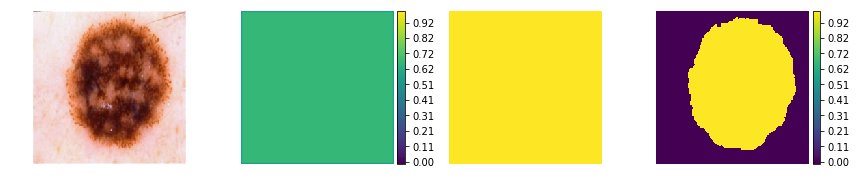

KeyboardInterrupt: 

In [19]:
run_model()

## Checkpoint - eval+View

In [21]:
g = build_fcn_graph()

model built


In [34]:
BMPs = load_obj("trial_catsdogs")
sess = tf.InteractiveSession(graph=g)
if BMPs:
    print("BMP!!!!!")
    restore_model_params(BMPs, g, sess)

BMP!!!!!


## Evaluate Model

In [23]:
# load dataset into memory
X_test = np.load(ROOT_DIR + '/test_images.npy')
y_test = np.load(ROOT_DIR + '/test_masks.npy')

# scale [-1, 1]
X_test = [(image-np.amin(image))/(np.amax(image)-np.amin(image)) for image in X_test]
X_test = np.asarray(X_test)
print(X_test[42][int(SQUARE_DIM/2)][int(SQUARE_DIM/2)])

# threshold masks
y_test = [np.clip(img, 0, 1).astype(np.int32) for img in y_test]
y_test = np.asarray(y_test)

print("X:{} , y:{}".format(X_test.shape, y_test.shape))

[ 0.80632412  0.60474306  0.49407116]
X:(600, 224, 224, 3) , y:(600, 224, 224)


In [ ]:
# # Ensure we've loaded correctly
# for i in range(6):
#     plt.figure();
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(10,3));
#     img = X_test[i,:,:]
#     mask = y_test[i,:,:]
#     img_copy = np.copy(img)
#     img_copy[mask == 0] = [0, 0, 0]
    
#     implot(img,ax1);
# #     print(X_train[i,0,0])
#     implot(mask,ax2);
#     implot(img_copy,ax3);
#     plt.grid('off');
#     plt.tight_layout();
# #     plt.savefig('images_{}.pdf'.format(i),dpi=600)
#     plt.show();

In [ ]:
# metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix

training_op, x, y, yhat, lesion_prob = g.get_collection("main_ops")

# ypred = np.argmax(yh,axis=3)
ji_scores = np.zeros(len(X_test))
DC_scores = np.zeros(len(X_test))
acc_scores = np.zeros(len(X_test))
sens_scores = np.zeros(len(X_test))
spec_scores = np.zeros(len(X_test))
for i in range(len(X_test)):
    cur_image = X_test[i]
    cur_image = np.expand_dims(cur_image, axis=0)
    GT = y_test[i]
   # _ = plot_four_array(sess, yhat, lesion_prob, X_test[:numberss], y_test[:numberss], i)
    y_softmax, y_lesion_prob = sess.run([yhat, lesion_prob],{x:cur_image})
    y_prediction = np.argmax(y_softmax,axis=3)
    ji = jaccard_similarity_score(y_true=GT, 
                                  y_pred=y_prediction[0])

    tn, fp, fn, tp = confusion_matrix(y_true=GT.flatten(), y_pred=y_prediction[0].flatten()).ravel()
    
    specificity = (tn / (tn+fp))
    sensitivity = (tp / (tp+fn))
    DC = ((2*tp)/(2*tp + fp + fn))
    acc = ((tp + tn) / (tn+fp+fn+tp))
    ji_scores[i] = ji
    DC_scores[i] = DC
    acc_scores[i] = acc
    sens_scores[i] = sensitivity
    spec_scores[i] = specificity
    if i % 20 == 0:
        print(i)

In [ ]:
print("JI : {:.4f} vs #1 {:.4f}".format(np.average(ji_scores), 0.765))
print("DC : {:.4f} vs #1 {:.4f}".format(np.average(DC_scores), 0.849))
print("ACC: {:.4f} vs #1 {:.4f}".format(np.average(acc_scores), 0.934))
print("SEN: {:.4f} vs #1 {:.4f}".format(np.average(sens_scores), 0.825))
print("SPC: {:.4f} vs #1 {:.4f}".format(np.average(spec_scores), 0.975))

## Results


### None
```
JI : 0.3384 vs #1 0.7650
DC : 0.4703 vs #1 0.8490
ACC: 0.6151 vs #1 0.9340
SEN: 0.9214 vs #1 0.8250
SPC: 0.5235 vs #1 0.9750

```
### 1500 zeros
```
xJI : 0.2909 vs #1 0.7650
xDC : 0.3687 vs #1 0.8490
xACC: 0.3269 vs #1 0.9340
xSEN: 0.9937 vs #1 0.8250
xSPC: 0.1273 vs #1 0.9750
```

### Cats+Dogs
```
JI : 0.5624 vs #1 0.7650
DC : 0.5717 vs #1 0.8490
ACC: 0.7757 vs #1 0.9340
SEN: 0.7398 vs #1 0.8250
SPC: 0.7873 vs #1 0.9750
```

## View Feature Maps

In [31]:
conv_featuremaps = g.get_collection("conv_featuremaps")
training_op, x, y, yhat, lesion_prob = g.get_collection("main_ops")
conv_featuremaps.append(yhat)

In [32]:
def create_all_conv_figures(conv_featuremaps, x, target_idx, zeros=False):
    global IMG_WIDTH, IMG_HEIGHT
    global X_val, y_val
    single_img = X_val[target_idx]
    zero_img = np.zeros_like(X_val[target_idx])
    if zeros:
        single_img = zero_img
    img_as_batch = np.expand_dims(single_img, axis=0)
    
    for i, maps in enumerate(conv_featuremaps):
    
        maps_out = sess.run(maps, feed_dict={x: img_as_batch})
        maps_out_len = maps_out.shape[3]
        reshape_maps = maps_out.reshape(IMG_WIDTH,IMG_HEIGHT,maps_out_len)
        if i == (len(conv_featuremaps)-1):
            plot_square_maps(reshape_maps, plot_as_zero_one=True)
        else:
            plot_square_maps(reshape_maps, plot_as_zero_one=False)

    # get mask from yhat (last tensor)
    y_prediction = np.argmax(reshape_maps,axis=2)
    y_prediction = np.expand_dims(y_prediction, axis=2)
    plot_square_maps(y_prediction) # target

    if zeros:
        plot_square_maps(np.expand_dims(np.zeros_like(y_val[target_idx]), axis=2)) # output
    else:
        plot_square_maps(np.expand_dims(y_val[target_idx], axis=2)) # output
    plot_square_maps(np.expand_dims(single_img, axis=2)) #image

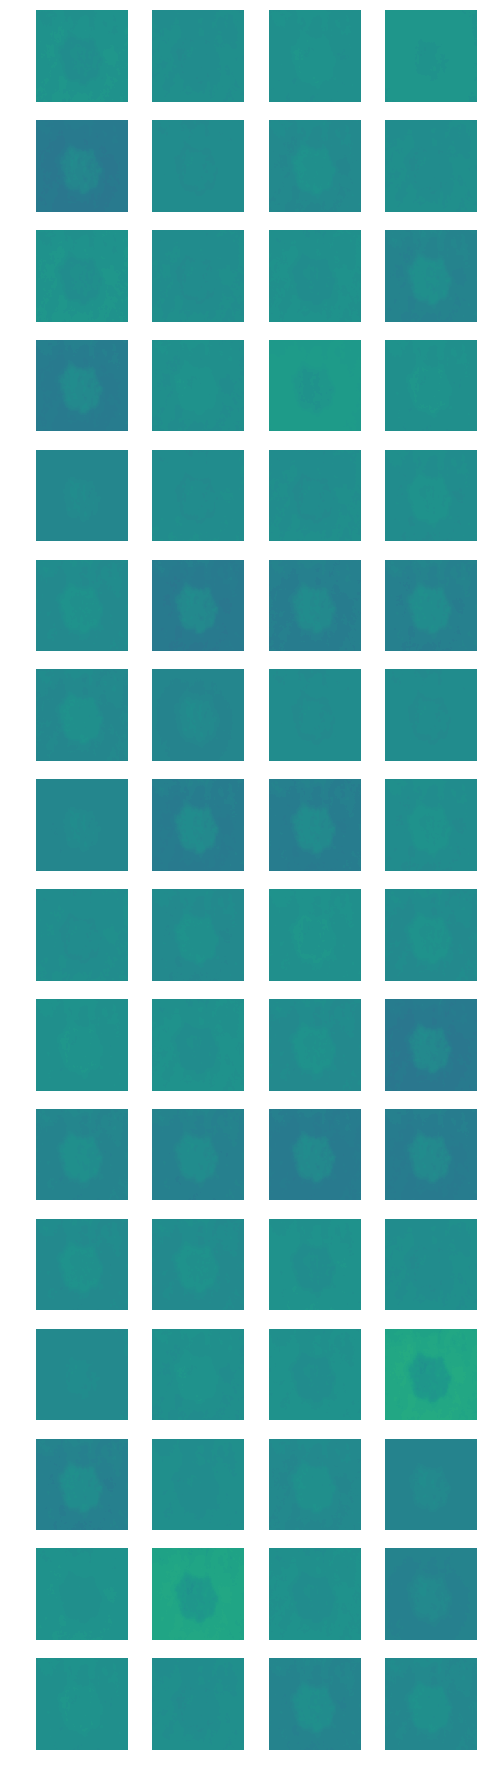

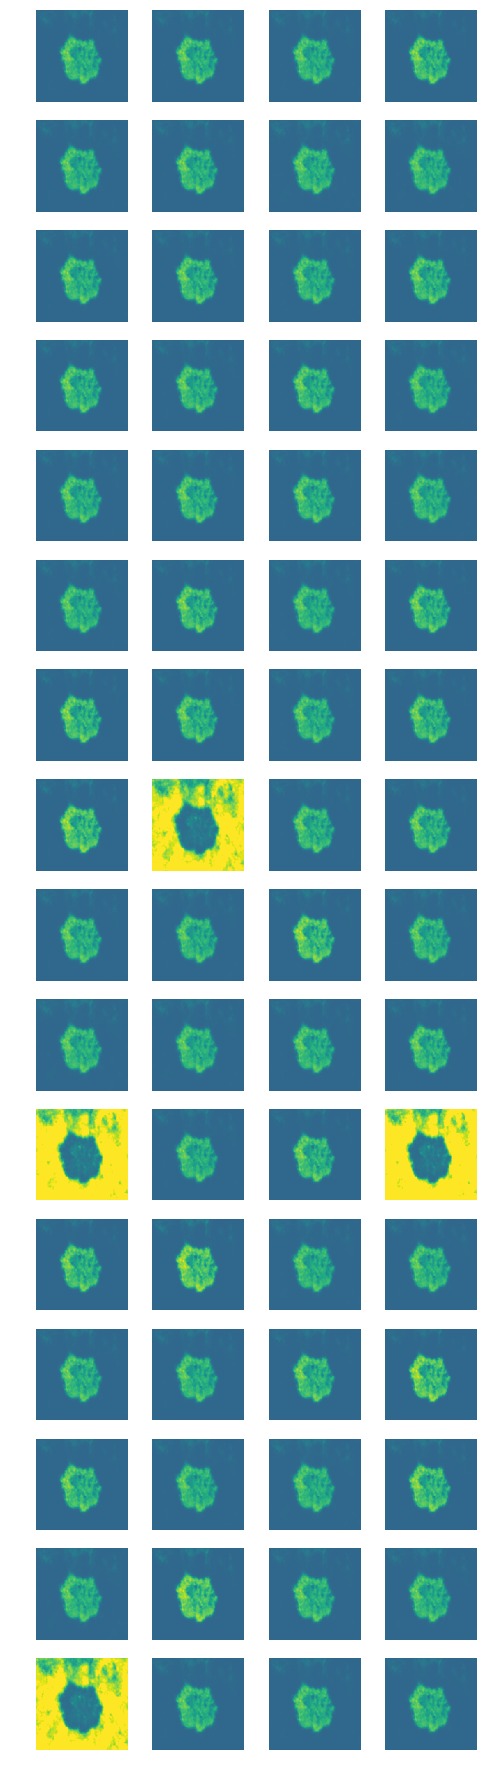

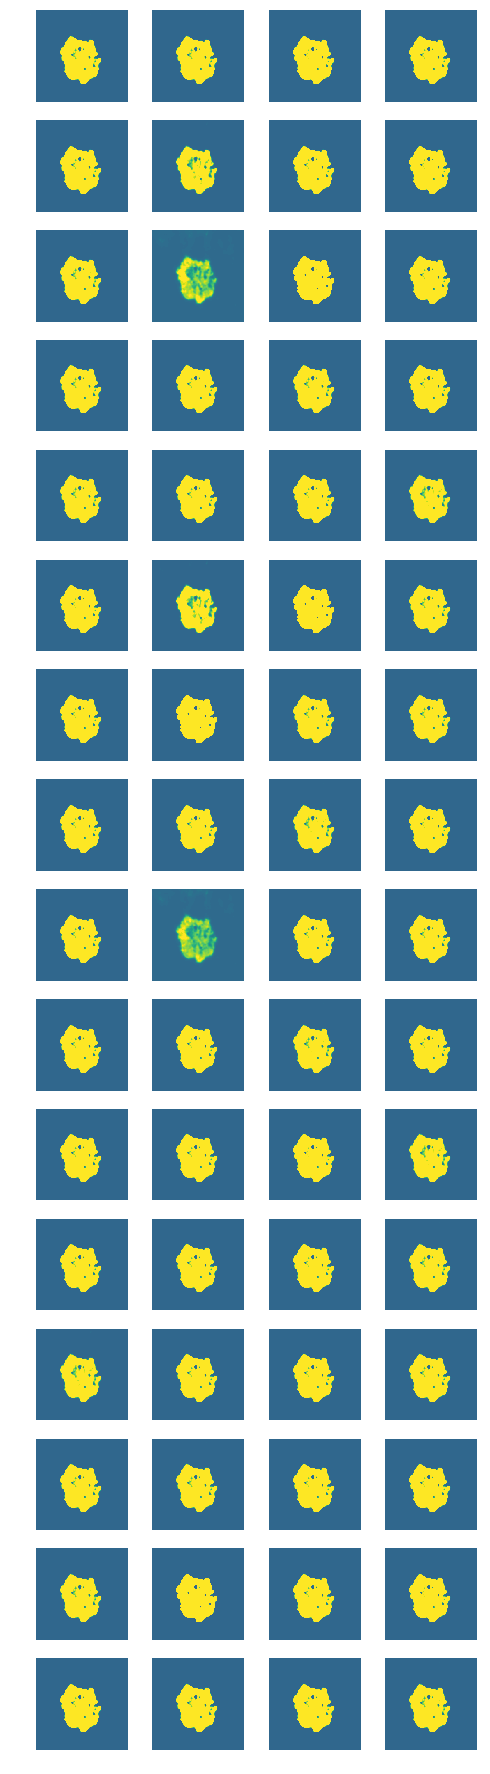

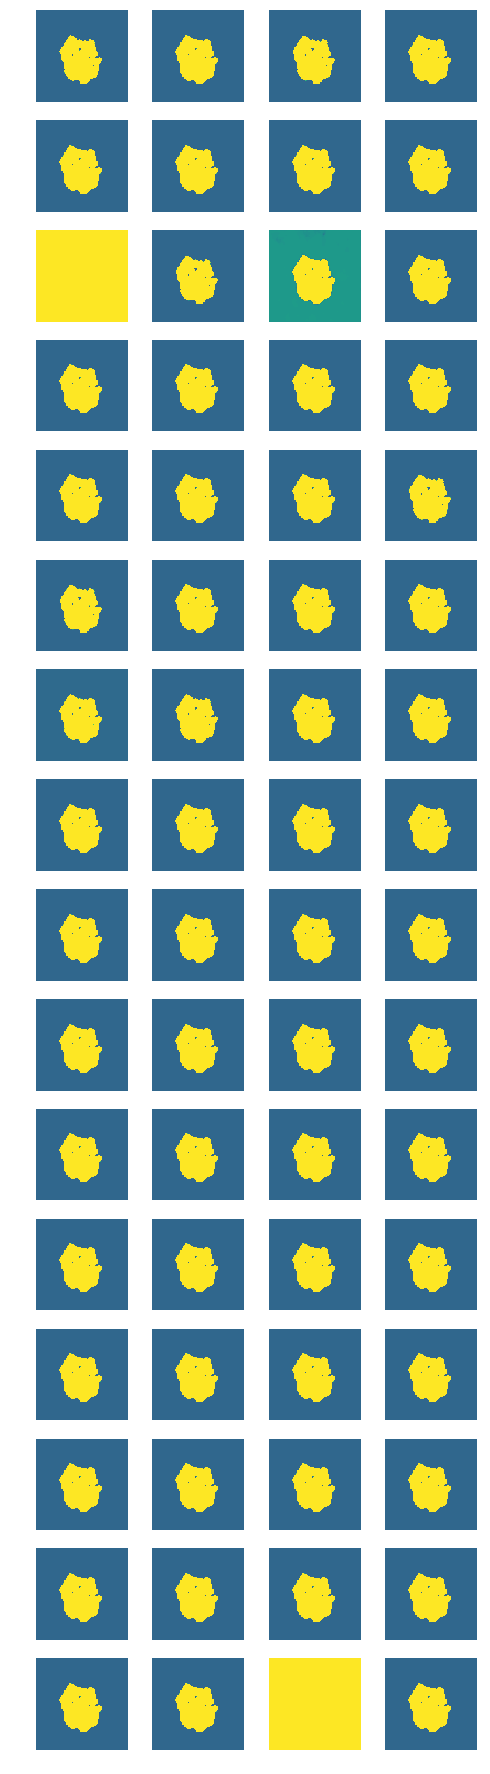

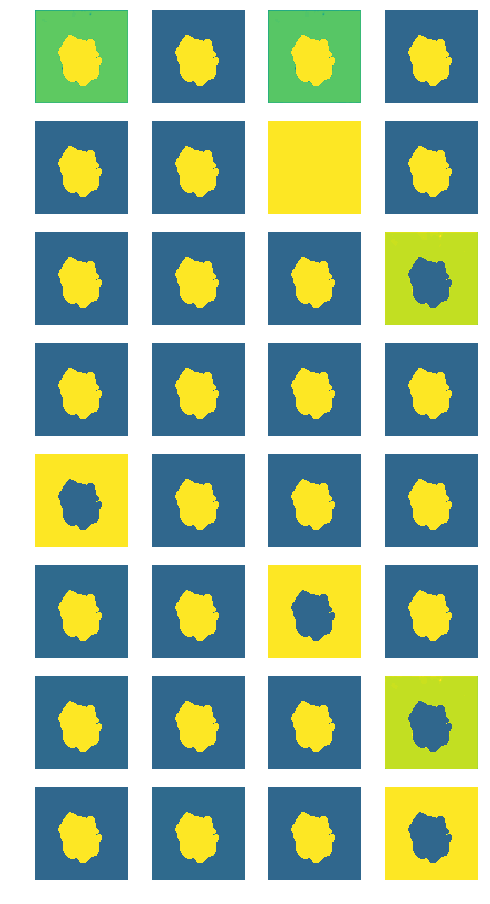

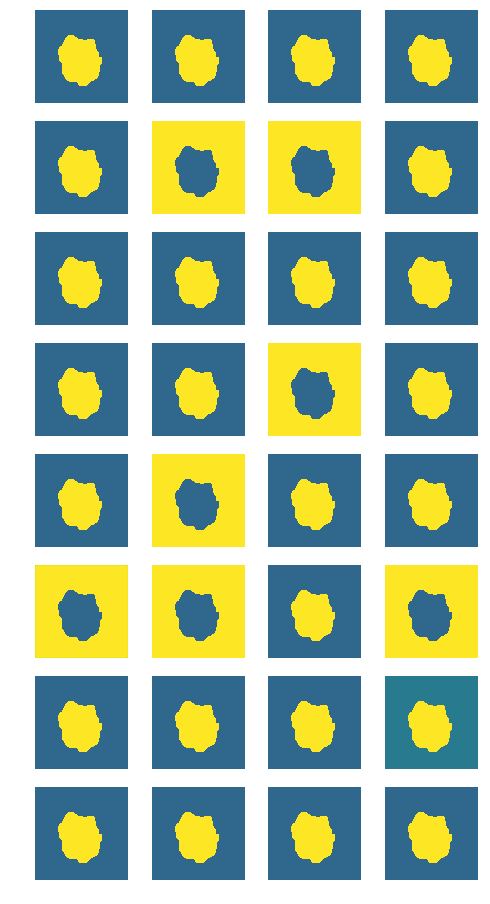

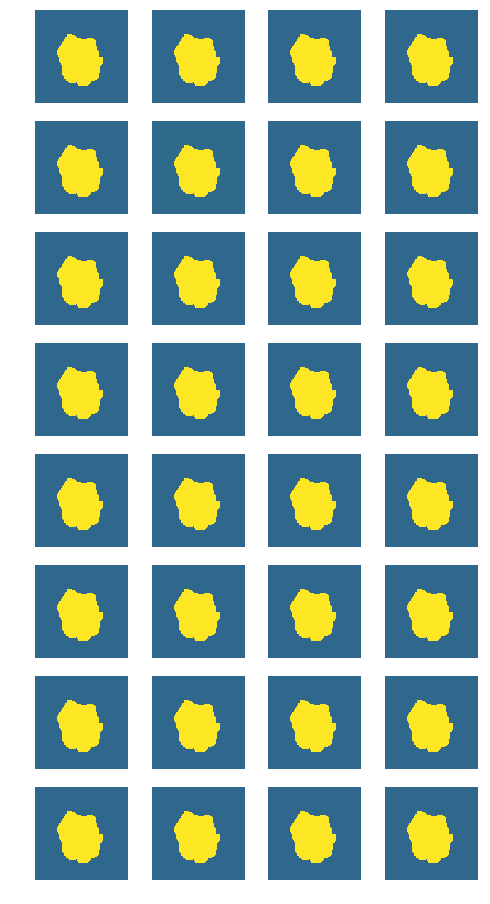

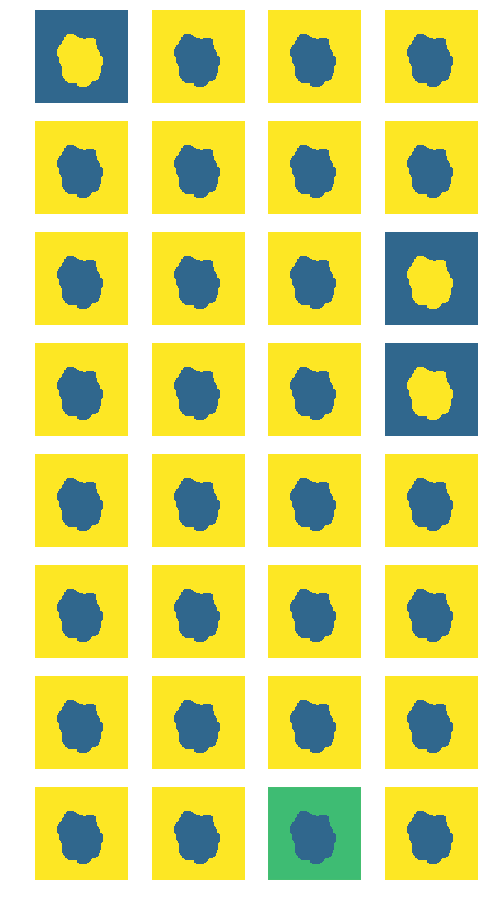

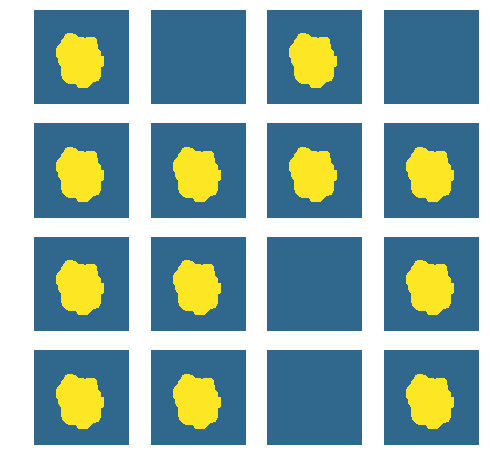

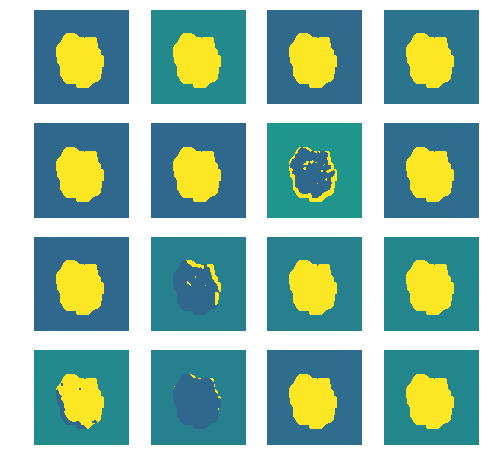

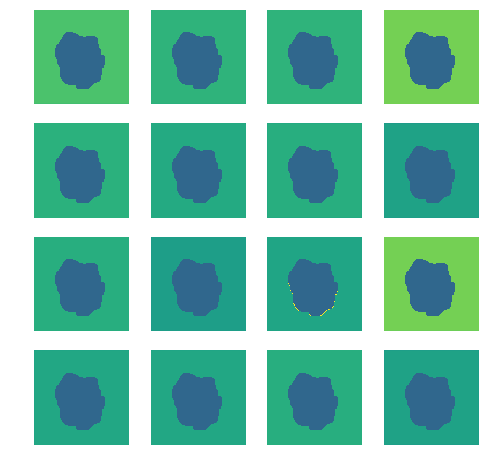

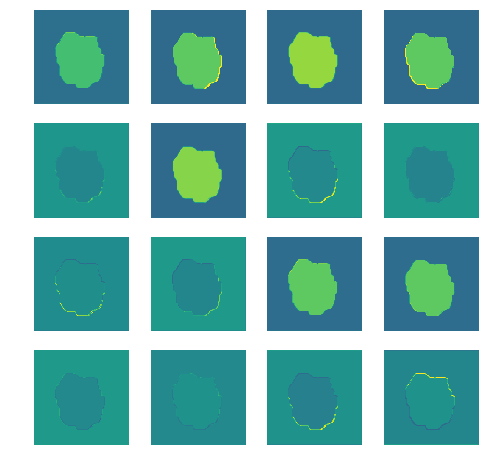

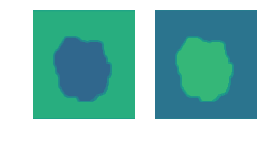

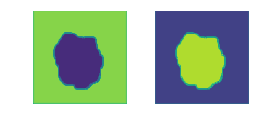

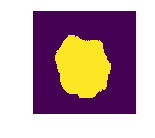

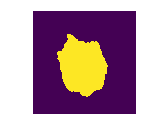

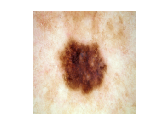

In [35]:
#create_all_conv_figures(conv_featuremaps, x, 1, zeros=True)
create_all_conv_figures(conv_featuremaps, x, 3, zeros=False)

In [37]:
X_test_batch = X_test[:10]
y_test_batch = y_test[:10]

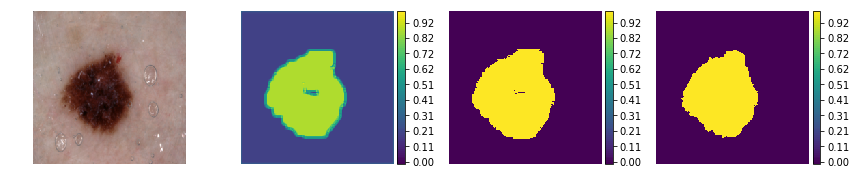

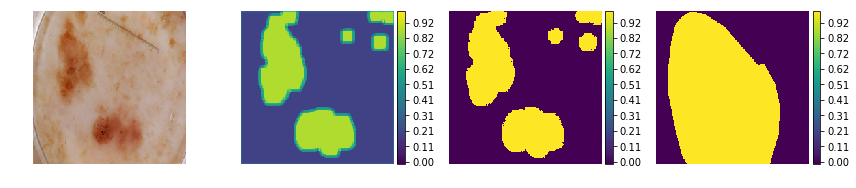

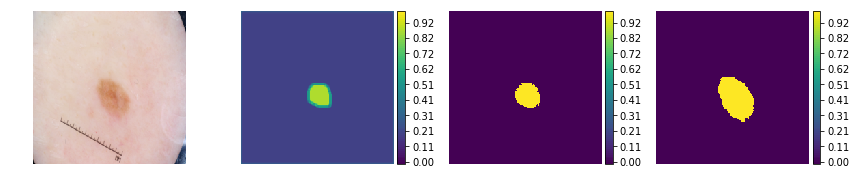

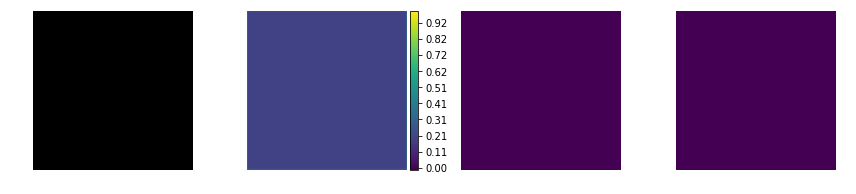

In [38]:
plot_four_array(sess, x, yhat, lesion_prob, X_test_batch, y_test_batch, 6,
                img_type="zeros2_test_6", epoch_num=25, SAVE_FIG=True)
plot_four_array(sess, x, yhat, lesion_prob, X_test_batch, y_test_batch, 2,
                img_type="zeros2_test_2", epoch_num=25, SAVE_FIG=True)
plot_four_array(sess, x, yhat, lesion_prob, X_test_batch, y_test_batch, 8,
                img_type="zeros2_test_8", epoch_num=25, SAVE_FIG=True)
plot_four_array(sess, x, yhat, lesion_prob, np.zeros_like(X_test_batch), np.zeros_like(y_test_batch), 8,
                img_type="zeros2_zero", epoch_num=25, SAVE_FIG=True)

In [39]:
sess.close()

## TODO:
1) eval performance on test set (spoiler, it overfitts)
2) improve performance
3) create time-lapse of output (conv layers, masks, val/test)